## Project brent oil

We have brent oil prices weekly for 30 years written in `brent_oil_weekly_30_years.csv` <br>
Contains `Date`  , `Open` , `High` , `Low` , `Vol` and `Change` As Features and ,`Price` as Target. <br>
The Goal Of This Project is To Build A `Time Series` Model And Predict Price Bases On Previous Datas.



### Import Dependencies

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


import warnings
warnings.filterwarnings('ignore')

In [87]:
df = pd.read_csv('brent_oil_weekly_30_years.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,04/09/2023,84.46,85.23,85.52,84.11,NaN,-0.78%
1,04/02/2023,85.12,86.00,86.44,83.50,1.29M,6.55%
2,03/26/2023,79.89,74.62,79.95,74.39,1.68M,6.53%
3,03/19/2023,74.99,73.01,77.44,70.12,1.06M,2.77%
4,03/12/2023,72.97,82.60,83.48,71.40,2.13M,-11.85%
...,...,...,...,...,...,...,...
1561,05/09/1993,18.60,19.25,19.27,18.51,89.64K,-3.07%
1562,05/02/1993,19.19,19.25,19.30,18.96,78.82K,0.21%
1563,04/25/1993,19.15,18.98,19.24,18.72,67.36K,1.27%
1564,04/18/1993,18.91,18.82,18.98,18.71,77.49K,0.53%


### Pre Processing

#### Changing Date To DateTime Object

In [88]:
df["Date"] = pd.to_datetime(df["Date"])
# df.set_index("Date", inplace=True)

df['Change %'].dtype

dtype('O')

#### Checking For NaN Values

In [89]:
df.isna().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        1
Change %    0
dtype: int64

#### Convert M to Million and K to Killo 

In [90]:
# remove M and K's
def convert_volume(val):
    if val[-1] == 'M':
        return int(float(val[:-1]) * 1000000)
    elif val[-1] == 'K':
        return int(float(val[:-1]) * 1000)
    else:
        return int(val)

In [91]:
df['Vol.'] = df['Vol.'].astype('str')
df['Vol.'][0] = '0'
df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Vol.'][0] = int(df['Vol.'].mean())

In [92]:
df['Vol.']

0        601114
1       1290000
2       1680000
3       1060000
4       2130000
         ...   
1561      89640
1562      78820
1563      67360
1564      77490
1565      79200
Name: Vol., Length: 1566, dtype: int64

#### Convert Percentages to Number

In [93]:
df['Change %'] = pd.to_numeric(df['Change %'].str.strip('%')) 


In [94]:
df['Change %'].head()

0    -0.78
1     6.55
2     6.53
3     2.77
4   -11.85
Name: Change %, dtype: float64

### Plotting Features 

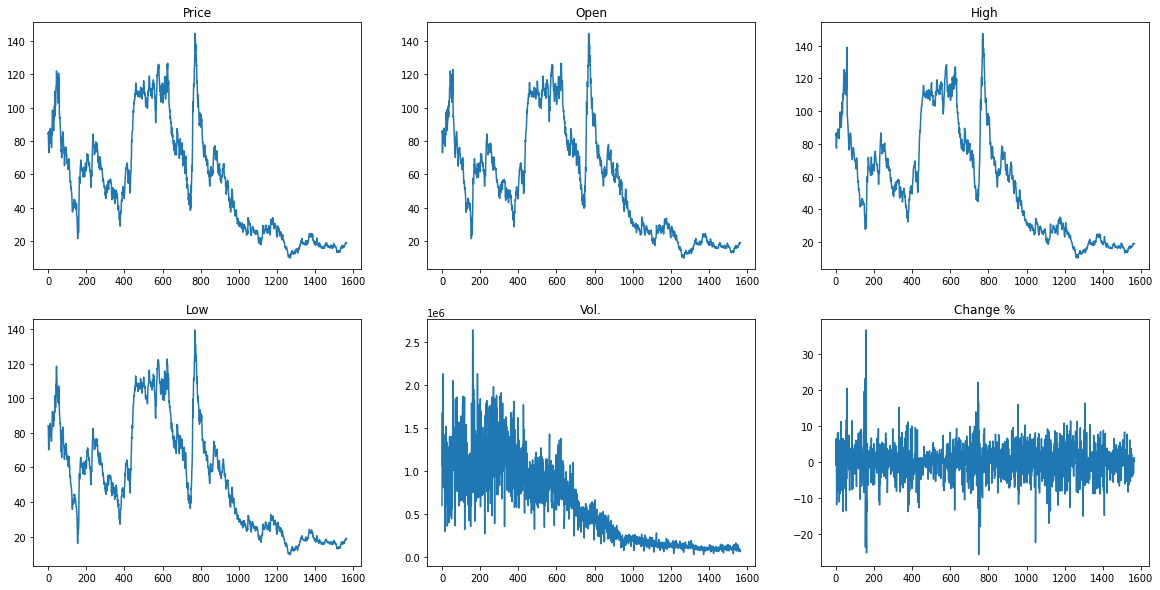

In [95]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

Feature_Names = np.array(list(df.columns[1::]))
Feature_Names = Feature_Names.reshape(2,3)

for i , feature in enumerate(df.columns[1::]):
    row = i // 3
    col = i % 3
    ax[row, col].plot(df[feature])
    ax[row, col].set_title(Feature_Names[row][col])


### Defining Function To Make Time Series Based On a Given Data 

In [96]:
def make_time_series(df, n, m):
    df_new = pd.DataFrame()
    df_new['Date'] = df['Date']

    for i in range(1, n+1):
        df_new['Price_t-'+str(i)] = df['Price'].shift(i)
        df_new['Open_t-'+str(i)] = df['Open'].shift(i)
        df_new['High_t-'+str(i)] = df['High'].shift(i)
        df_new['Low_t-'+str(i)] = df['Low'].shift(i)
        df_new['Vol._t-'+str(i)] = df['Vol.'].shift(i)
        df_new['Change %_t-'+str(i)] = df['Change %'].shift(i)

    for i in range(1, m+1):
        df_new['Price_t+'+str(i)] = df['Price'].shift(-i)

    return df_new

In [132]:
ndf = make_time_series(df , 2 , 4 )
ndf.head()

,Date,Price_t-1,Open_t-1,High_t-1,Low_t-1,Vol._t-1,Change %_t-1,Price_t-2,Open_t-2,High_t-2,Low_t-2,Vol._t-2,Change %_t-2,Price_t+1,Price_t+2,Price_t+3,Price_t+4
0,2023-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.12,79.89,74.99,72.97
1,2023-04-02,84.46,85.23,85.52,84.11,601114.0,-0.78,NaN,NaN,NaN,NaN,NaN,NaN,79.89,74.99,72.97,82.78
2,2023-03-26,85.12,86.00,86.44,83.50,1290000.0,6.55,84.46,85.23,85.52,84.11,601114.0,-0.78,74.99,72.97,82.78,85.83
3,2023-03-19,79.89,74.62,79.95,74.39,1680000.0,6.53,85.12,86.00,86.44,83.50,1290000.0,6.55,72.97,82.78,85.83,83.16
4,2023-03-12,74.99,73.01,77.44,70.12,1060000.0,2.77,79.89,74.62,79.95,74.39,1680000.0,6.53,82.78,85.83,83.16,83.00


### Training Models Based On Time Series

Splitting Datas Before 2019 For Traing And Datas After 2019 For test 

In [98]:

test_data = df[df['Date'].dt.year >= 2019]
train_data = df[df['Date'].dt.year < 2019]

X_train = df[df['Date'].dt.year < 2019].drop('Price', axis=1)
y_train = df[df['Date'].dt.year < 2019]['Price']


y_test = df[df['Date'].dt.year >= 2019]['Price']

In [131]:
X_Train_TimeSeries = make_time_series(train_data , 8 , 1)
X_Train_TimeSeries = X_Train_TimeSeries.fillna(X_Train_TimeSeries.mean())
X_Train_TimeSeries.drop('Date' , axis=1 , inplace=True)

X_Test_TimeSeries  = make_time_series(test_data , 8 , 1)
X_Test_TimeSeries  = X_Test_TimeSeries .fillna(X_Test_TimeSeries .mean())
X_Test_TimeSeries.drop('Date' , axis=1 , inplace=True)




In [100]:
import re

i = 0
indexes = []
for column in X_Train_TimeSeries.columns:
    if re.search('^Price', column):
        indexes.append(i)
    i += 1

X_Train_TimeSeries = X_Train_TimeSeries.iloc[:,indexes]
X_Train_TimeSeries

,Price_t-1,Price_t-2,Price_t-3,Price_t-4,Price_t-5,Price_t-6,Price_t-7,Price_t-8,Price_t+1
223,52.649449,52.674609,52.699627,52.724653,52.750157,52.775826,52.801407,52.827243,52.200000
224,57.060000,52.674609,52.699627,52.724653,52.750157,52.775826,52.801407,52.827243,53.820000
225,52.200000,57.060000,52.699627,52.724653,52.750157,52.775826,52.801407,52.827243,60.280000
226,53.820000,52.200000,57.060000,52.724653,52.750157,52.775826,52.801407,52.827243,61.670000
227,60.280000,53.820000,52.200000,57.060000,52.750157,52.775826,52.801407,52.827243,58.710000
...,...,...,...,...,...,...,...,...,...
1561,18.430000,18.600000,18.310000,17.660000,17.560000,17.450000,16.740000,16.650000,19.190000
1562,18.600000,18.430000,18.600000,18.310000,17.660000,17.560000,17.450000,16.740000,19.150000
1563,19.190000,18.600000,18.430000,18.600000,18.310000,17.660000,17.560000,17.450000,18.910000
1564,19.150000,19.190000,18.600000,18.430000,18.600000,18.310000,17.660000,17.560000,18.810000


In [101]:
import re

i = 0
indexes = []
for column in X_Test_TimeSeries.columns:
    if re.search('^Price', column):
        indexes.append(i)
    i += 1

X_Test_TimeSeries = X_Test_TimeSeries.iloc[:,indexes]
X_Test_TimeSeries

,Price_t-1,Price_t-2,Price_t-3,Price_t-4,Price_t-5,Price_t-6,Price_t-7,Price_t-8,Price_t+1
0,70.44018,70.475204,70.515364,70.550822,70.589587,70.609585,70.625741,70.651581,85.120000
1,84.46000,70.475204,70.515364,70.550822,70.589587,70.609585,70.625741,70.651581,79.890000
2,85.12000,84.460000,70.515364,70.550822,70.589587,70.609585,70.625741,70.651581,74.990000
3,79.89000,85.120000,84.460000,70.550822,70.589587,70.609585,70.625741,70.651581,72.970000
4,74.99000,79.890000,85.120000,84.460000,70.589587,70.609585,70.625741,70.651581,82.780000
...,...,...,...,...,...,...,...,...,...
218,66.25000,67.120000,65.070000,65.740000,67.160000,67.030000,68.390000,70.340000,62.750000
219,62.10000,66.250000,67.120000,65.070000,65.740000,67.160000,67.030000,68.390000,61.640000
220,62.75000,62.100000,66.250000,67.120000,65.070000,65.740000,67.160000,67.030000,62.700000
221,61.64000,62.750000,62.100000,66.250000,67.120000,65.070000,65.740000,67.160000,60.480000


In [102]:
X_Train_TimeSeries.head()

,Price_t-1,Price_t-2,Price_t-3,Price_t-4,Price_t-5,Price_t-6,Price_t-7,Price_t-8,Price_t+1
223,52.649449,52.674609,52.699627,52.724653,52.750157,52.775826,52.801407,52.827243,52.20
224,57.060000,52.674609,52.699627,52.724653,52.750157,52.775826,52.801407,52.827243,53.82
225,52.200000,57.060000,52.699627,52.724653,52.750157,52.775826,52.801407,52.827243,60.28
226,53.820000,52.200000,57.060000,52.724653,52.750157,52.775826,52.801407,52.827243,61.67
227,60.280000,53.820000,52.200000,57.060000,52.750157,52.775826,52.801407,52.827243,58.71


#### Linear Regression 

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


lr = LinearRegression().fit(X_Train_TimeSeries , y_train)

y_pred_lr = lr.predict(X_Test_TimeSeries)

print('Mean Absolute Error:', mean_absolute_error(y_pred_lr, y_test))
print('Mean Squared Error:', mean_squared_error(y_pred_lr, y_test))


Mean Absolute Error: 2.1422792949340796
Mean Squared Error: 9.625816980827175


#### Gradiant Regressor

In [104]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor().fit(X_Train_TimeSeries,y_train)

y_pred_gb = gb.predict(X_Test_TimeSeries)

print('Mean Absolute Error:', mean_absolute_error(y_pred_gb, y_test))
print('Mean Squared Error:', mean_squared_error(y_pred_gb, y_test))

Mean Absolute Error: 2.2494981008166124
Mean Squared Error: 10.407005527476096


#### SVR 

In [105]:
from sklearn.svm import SVR 

sv = SVR().fit(X_Train_TimeSeries,y_train)
y_pred_sv = sv.predict(X_Test_TimeSeries)

print('Mean Absolute Error:', mean_absolute_error(y_pred_sv, y_test))
print('Mean Squared Error:', mean_squared_error(y_pred_sv, y_test))


Mean Absolute Error: 2.704250852446875
Mean Squared Error: 13.741329085555252


#### Decision Tree Regressor 

In [106]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor().fit(X_Train_TimeSeries,y_train)

y_pred_dt = dt.predict(X_Test_TimeSeries)

print('Mean Absolute Error:', mean_absolute_error(y_pred_dt, y_test))
print('Mean Squared Error:', mean_squared_error(y_pred_dt, y_test))

Mean Absolute Error: 2.949596412556054
Mean Squared Error: 16.499083408071748


### Plotting Real Chart And Our Prediction

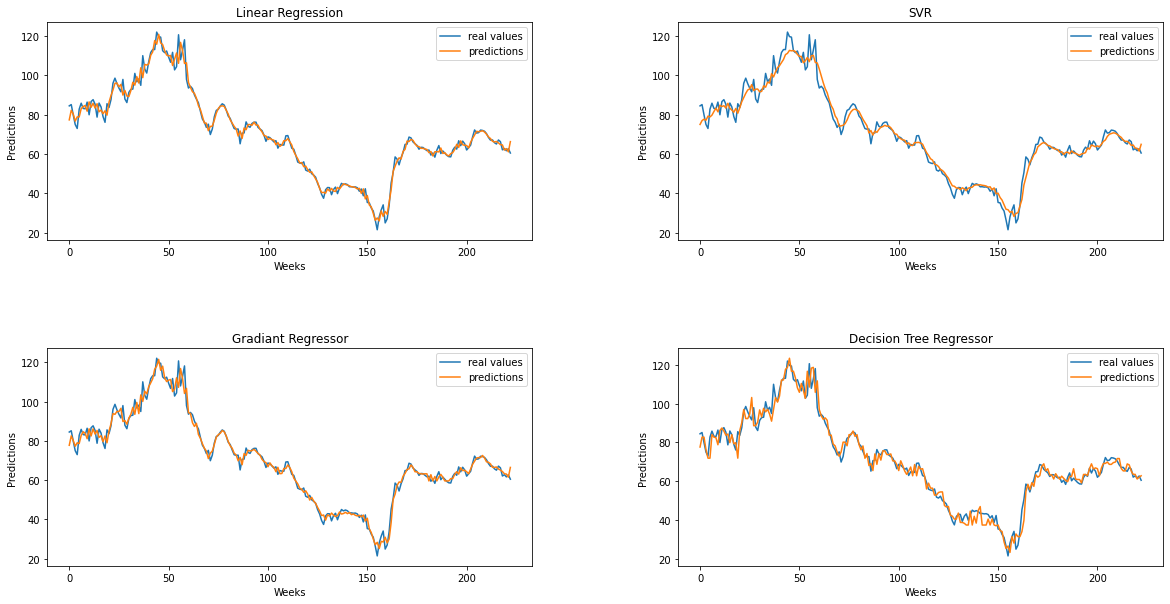

In [107]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

ax[0][0].plot(y_test, label='real values')
ax[0][0].plot(y_pred_lr, label='predictions')
ax[0][0].set_title('Linear Regression')
ax[0][0].set_xlabel('Weeks')
ax[0][0].set_ylabel('Predictions')
ax[0][0].legend()

ax[0][1].plot(y_test, label='real values')
ax[0][1].plot(y_pred_sv, label='predictions')
ax[0][1].set_title('SVR')
ax[0][1].set_xlabel('Weeks')
ax[0][1].set_ylabel('Predictions')
ax[0][1].legend()

ax[1][0].plot(y_test, label='real values')
ax[1][0].plot(y_pred_gb, label='predictions')
ax[1][0].set_title('Gradiant Regressor')
ax[1][0].set_xlabel('Weeks')
ax[1][0].set_ylabel('Predictions')
ax[1][0].legend()

ax[1][1].plot(y_test, label='real values')
ax[1][1].plot(y_pred_dt, label='predictions')
ax[1][1].set_title('Decision Tree Regressor')
ax[1][1].set_xlabel('Weeks')
ax[1][1].set_ylabel('Predictions')
ax[1][1].legend()

plt.show()

### Trying Diffrent n's For Time Series Function

In [108]:
# accs = []
# for i in range(1,15):
#     Train_Data_Temp = make_time_series(train_data , i , 1)
#     Train_Data_Temp = Train_Data_Temp.fillna(Train_Data_Temp.mean())
#     Train_Data_Temp.drop('Date' , axis=1 , inplace=True)
#     # print(train_data)
    
    
#     X_Test_Temp = make_time_series(test_data , i , 1)
#     X_Test_Temp = X_Test_Temp.fillna(X_Test_Temp.mean())
#     X_Test_Temp.drop('Date' , axis=1 , inplace=True)
#     # print(X_Test_Temp.columns)
#     # print(test_data)
#     lr_temp = LinearRegression().fit(Train_Data_Temp , y_train)

#     y_pred_lr_temp = lr_temp.predict(X_Test_Temp)
    
#     accs.append( mean_squared_error(y_pred_lr_temp, y_test))
        
import re

accs = []
for i in range(1,15):
    train_data_new_temp = make_time_series(train_data, i, 1)
    train_data_new_temp = train_data_new_temp.fillna(train_data_new_temp.mean())
    train_data_new_temp.drop('Date' , axis=1 , inplace=True)

    j = 0
    indexes = []
    for column in train_data_new_temp.columns:
        if re.search('^Price', column):
            indexes.append(j)
        j += 1

    train_data_new_temp = train_data_new_temp.iloc[:,indexes]

    test_data_new_temp = make_time_series(test_data, i, 1)
    test_data_new_temp = test_data_new_temp.fillna(test_data_new_temp.mean())
    test_data_new_temp.drop('Date' , axis=1 , inplace=True)

    j = 0
    indexes = []
    for column in test_data_new_temp.columns:
        if re.search('^Price', column):
            indexes.append(j)
        j += 1

    test_data_new_temp = test_data_new_temp.iloc[:,indexes]
    X_test_new_temp = test_data_new_temp

    lr_temp = LinearRegression().fit(train_data_new_temp, y_train)

    y_pred_lr_temp = lr_temp.predict(X_test_new_temp)

    accs.append(mean_squared_error(y_pred_lr_temp, y_test))

### Plotting Features 

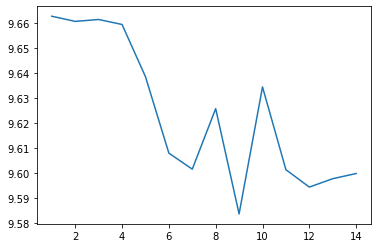

Best Score at n = 9


In [130]:
plt.plot(list(range(1,15)),accs)
plt.show()
print(f"Best Score at n = {np.argmin(accs)+1}")

### Define A New Function To Use All Future Features


In [110]:
def make_time_series_use_all_features(df, n, m):
    df_new = pd.DataFrame()
    df_new['Date'] = df['Date']

    for i in range(1, n+1):
        df_new['Price_t-'+str(i)] = df['Price'].shift(i)
        df_new['Open_t-'+str(i)] = df['Open'].shift(i)
        df_new['High_t-'+str(i)] = df['High'].shift(i)
        df_new['Low_t-'+str(i)] = df['Low'].shift(i)
        df_new['Vol._t-'+str(i)] = df['Vol.'].shift(i)
        df_new['Change %_t-'+str(i)] = df['Change %'].shift(i)

    for i in range(1, m+1):
        df_new['Price_t+'+str(i)] = df['Price'].shift(-i)
        df_new['Open_t+'+str(i)] = df['Open'].shift(-i)
        df_new['High_t+'+str(i)] = df['High'].shift(-i)
        df_new['Low_t+'+str(i)] = df['Low'].shift(-i)
        df_new['Vol._t+'+str(i)] = df['Vol.'].shift(-i)
        df_new['Change %_t+'+str(i)] = df['Change %'].shift(-i)

    return df_new


In [111]:
X_Train_TimeSeries_All = make_time_series_use_all_features(train_data, 5, 1)
X_Train_TimeSeries_All = X_Train_TimeSeries_All.fillna(X_Train_TimeSeries_All.mean())
X_Train_TimeSeries_All.drop('Date' , axis=1 , inplace=True)

X_Test_TimeSeries_All = make_time_series_use_all_features(test_data, 5, 1)
X_Test_TimeSeries_All = X_Test_TimeSeries_All.fillna(X_Test_TimeSeries_All.mean())
X_Test_TimeSeries_All.drop('Date' , axis=1 , inplace=True)




In [112]:

lr2 = LinearRegression().fit(X_Train_TimeSeries_All, y_train)
y_pred_lr2 = lr2.predict(X_Test_TimeSeries_All)
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean Absolute Error for LinearRegression:', mean_absolute_error(y_pred_lr2, y_test))
print('Mean Squared Error for LinearRegression:', mean_squared_error(y_pred_lr2, y_test))

Mean Absolute Error for LinearRegression: 0.5939255372235183
Mean Squared Error for LinearRegression: 1.9911771675765741


In [113]:
from sklearn.feature_selection import SequentialFeatureSelector

lr_best = LinearRegression()

sfs = SequentialFeatureSelector(lr_best , n_features_to_select= 12 , direction='forward' , cv=5)
sfs.fit(X_Train_TimeSeries_All,y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=12)

In [114]:
selected_indices = sfs.get_support(indices=True)
selected_names = list(X_Train_TimeSeries_All.columns[selected_indices])
print(selected_names)


['Open_t-1', 'Change %_t-1', 'Price_t-2', 'High_t-2', 'Low_t-2', 'Vol._t-2', 'Open_t-3', 'Vol._t-3', 'Price_t-5', 'Change %_t-5', 'Price_t+1', 'Change %_t+1']


In [115]:
X_Train_best_features = X_Train_TimeSeries_All.loc[:, selected_names]
X_Test_best_featues = X_Test_TimeSeries_All.loc[:, selected_names]

In [116]:
lr_best_features = LinearRegression().fit(X_Train_best_features,y_train)
y_pred_best_features = lr_best_features.predict(X_Test_best_featues)
print('Mean Absolute Error for LinearRegression:', mean_absolute_error(y_pred_best_features, y_test))
print('Mean Squared Error for LinearRegression:', mean_squared_error(y_pred_best_features, y_test))


Mean Absolute Error for LinearRegression: 0.5954267712994811
Mean Squared Error for LinearRegression: 2.073480330326117


## Predict Price Based On 12 Weeks 

In [117]:
df_16_Weeks = df.iloc[:16]
train_data_12_weeks = df_16_Weeks.iloc[:12]

X_train_12_weeks = train_data_12_weeks.drop(['Price' , 'Date'] , axis=1)
y_train_12_weeks = train_data_12_weeks['Price']

test_data_4_weeks = df_16_Weeks.iloc[-4:]
y_test_4_weeks = test_data_4_weeks['Price']
X_test_4_weeks = test_data_4_weeks.drop(['Price' , 'Date'] , axis=1)

In [118]:

lr_12_weeks = LinearRegression().fit(X_train_12_weeks,y_train_12_weeks)

y_pred_4_weeks = lr_12_weeks.predict(X_test_4_weeks)
print('Mean Absolute Error' ,mean_absolute_error(y_pred_4_weeks , y_test_4_weeks))
print('Mean Squared Error' ,mean_squared_error(y_pred_4_weeks , y_test_4_weeks))

Mean Absolute Error 0.9345030286280966
Mean Squared Error 1.5825724943429846


## GridSearch For GradiantBoostingRegressor

In [119]:
from sklearn.model_selection import GridSearchCV


gb2 = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

gs = GridSearchCV(estimator=gb2 , param_grid=param_grid , cv=2 , n_jobs=-1 , verbose=1)

gs.fit(X_train_12_weeks,y_train_12_weeks)

Fitting 2 folds for each of 243 candidates, totalling 486 fits


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=1)

In [120]:
gb_b = GradientBoostingRegressor(**gs.best_params_).fit(X_train_12_weeks,y_train_12_weeks)

y_pred_gb_2  = gb_b.predict(X_test_4_weeks)
print('Mean Squared Error' ,mean_squared_error(y_test_4_weeks,y_pred_gb_2))

Mean Squared Error 3.0349500000000065


### Use EMD (Empirical Mode Decomposition ) Features To Improve Our Model

In [121]:
from PyEMD import EMD
emd = EMD()

In [122]:
imfs = emd(df['Price'].values)
short_term = imfs[0]
mid_term = imfs[1:4].sum(axis=0)
long_term = imfs[4:].sum(axis=0)

df_emd = df.copy()


In [123]:
df_emd['short_term'] = short_term
df_emd['mid_term'] = mid_term
df_emd['long_term'] = long_term

In [124]:
df_16_Weeks_emd = df_emd.iloc[:16]
train_data_12_weeks_emd = df_16_Weeks_emd.iloc[:12]

y_train_12_weeks_emd = train_data_12_weeks_emd['Price']
X_train_12_weeks_emd = train_data_12_weeks_emd.drop(['Price' , 'Date'] , axis=1)

test_data_4_weeks_emd = df_16_Weeks_emd.iloc[-4:]
y_test_4_weeks_emd = test_data_4_weeks_emd['Price']
X_test_4_weeks_emd = test_data_4_weeks_emd.drop(['Price' , 'Date'] , axis=1)

In [125]:

lr_12_weeks_emd = LinearRegression().fit(X_train_12_weeks_emd,y_train_12_weeks_emd)
y_pred_4_weeks_emd = lr_12_weeks_emd.predict(X_test_4_weeks_emd)
print ( f" MSE With EMD  = {mean_squared_error(y_pred_4_weeks_emd , y_test_4_weeks_emd)}")
print(f" MAE With EMD = {mean_absolute_error(y_pred_4_weeks_emd , y_test_4_weeks_emd)}")
print(" They're Almost Zero 0_0")

 MSE With EMD  = 1.2621774483536189e-27
 MAE With EMD = 3.197442310920451e-14
 They're Almost Zero 0_0


## Model Stacking

In [126]:
lr_m = LinearRegression().fit(X_train_12_weeks_emd , y_train_12_weeks_emd)
dt_m = DecisionTreeRegressor().fit(X_train_12_weeks_emd , y_train_12_weeks_emd)
gb_m = GradientBoostingRegressor().fit(X_train_12_weeks_emd , y_train_12_weeks_emd)

lr_preds = lr_m.predict(X_test_4_weeks_emd)
tree_preds = dt_m.predict(X_test_4_weeks_emd)
gb_preds = gb_m.predict(X_test_4_weeks_emd)

X_stacked = np.column_stack((lr_preds, tree_preds, gb_preds))


model_final = LinearRegression().fit(X_stacked , y_test_4_weeks_emd)

In [127]:
stacked_preds = model_final.predict(X_stacked)

print(f"MSE = {mean_squared_error(stacked_preds , y_test_4_weeks_emd)}")

MSE = 5.048709793414476e-28
